In [1]:
import argparse
import os 
import numpy as np 
import math 
import sys 
import time
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn 
import torch.nn.functional as F 
import torch 

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00002, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=1, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=20, help="interval between saving samples")
opt = parser.parse_args(args=[])
opt

Namespace(batch_size=128, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=2e-05, n_cpu=8, n_critic=1, n_epochs=1000, sample_interval=20)

In [3]:
img_shape = (opt.channels,opt.img_size,opt.img_size)
cuda = True if torch.cuda.is_available() else False
# Create sample and checkpoint directories
time_now = time.strftime('WGAN_%Y-%m-%d-%H_%M_%S', time.localtime(time.time()))
log_path = f'./log/{time_now}'
os.makedirs(log_path)
os.makedirs(f'{log_path}/image')
os.makedirs(f'{log_path}/image/image_all')

## Datasets

In [4]:
from torch.utils.data import Dataset,DataLoader
from mlxtend.data import loadlocal_mnist
import torchvision.transforms as transforms


class MNIST_Dataset(Dataset):
    def __init__(self,train_data_path,train_label_path,transform=None):
        train_data,train_label = loadlocal_mnist(
            images_path=train_data_path,
            labels_path=train_label_path,
        )
        self.train_data = train_data
        self.train_label = train_label
        self.transform = transform
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
        images = self.train_data[index,:].reshape((opt.img_size,opt.img_size))
        labels = self.train_label[index]
        if self.transform:
            images = self.transform(images)
        return images,labels
    
    def __len__(self):
        return self.train_label.shape[0]
    
train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])]
)
dataset = MNIST_Dataset(train_data_path,train_label_path,transform)
dataloader = DataLoader(dataset,batch_size=opt.batch_size,shuffle=True)

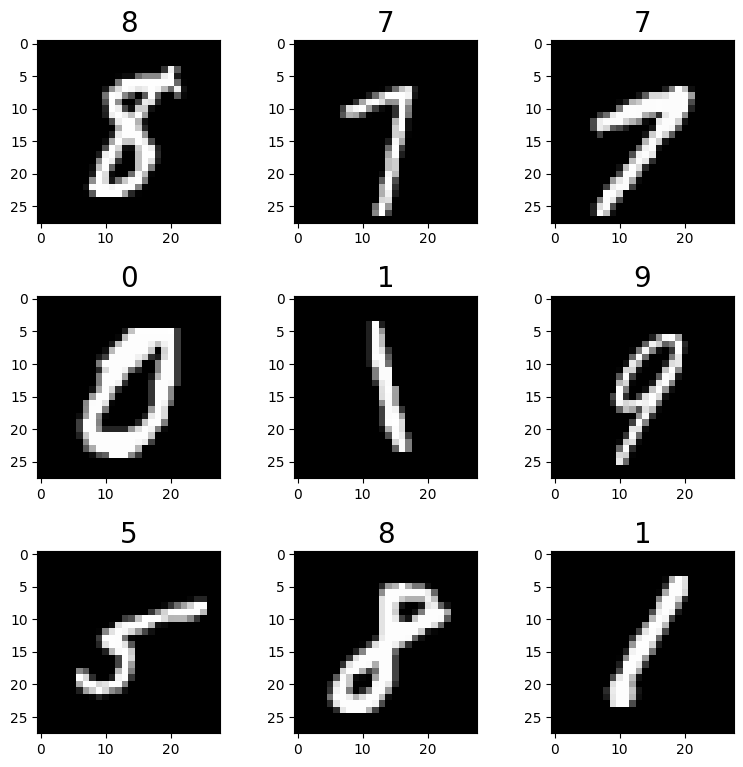

In [5]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(3,3,figsize=(9,9))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(3):
    for j in range(3):
        num = np.random.randint(0,opt.batch_size)
        ax[i][j].imshow(dataset[num][0].reshape((28,28)),cmap="gray")
        ax[i][j].set_title(dataset[num][1],fontdict={"fontsize":20})
plt.show()

## Model

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        def block(in_feature,out_feature,normalize=True):
            layers = [nn.Linear(in_feature,out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature,0.8))
            layers.append(nn.LeakyReLU(0.1,inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(opt.latent_dim,128,normalize=False),
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.shape[0],*img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(512,256), 
            nn.LeakyReLU(0.1,inplace=True), 
            nn.Linear(256,1),
        )
    
    def forward(self,img):
        img_flat = img.view(img.shape[0],-1)
        validity = self.model(img_flat)
        return validity

generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

## Training

In [7]:
optimizer_G = torch.optim.RMSprop(generator.parameters(),lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(),lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
gen_loss_list = []
dis_loss_list = []
for epoch in range(opt.n_epochs):
    with tqdm(total=dataloader.__len__(),desc=f"Epoch {epoch + 1}/{opt.n_epochs}") as pbar:
        gen_loss_avg = [0]
        dis_loss_avg = [0]
        index = 0
        for batch,(imgs,_) in enumerate(dataloader):
            # Configure input 
            real_imgs = Variable(imgs.type(Tensor))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # sample noise as generator input
            z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0],opt.latent_dim))))
            
            # generate a batch of images
            fack_imgs = generator(z).detach()
            
            # adversarial loss
            loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fack_imgs))
            dis_loss_avg.append(loss_D.item())
            
            loss_D.backward()
            optimizer_D.step()
            
            # Clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(min=-opt.clip_value,max=opt.clip_value)

            # Train the generator every n_critic iterations
            if batch%opt.n_critic ==0:
                # -----------------
                #  Train Generator
                # -----------------
                optimizer_G.zero_grad()
                
                # generate a batch of images
                gen_imgs = generator(z)
                
                #adversarial loss
                loss_G = -torch.mean(discriminator(gen_imgs))
                gen_loss_avg.append(loss_G.item())
                
                loss_G.backward()
                optimizer_G.step()
            
            # # save figure
            # if index % 500 == 0 or index + 1 == dataset.__len__():
            #     save_image(fack_imgs, f'{log_path}/image/image_all/epoch-{epoch}-index-{index}.png')
            # index += 1
            
            # ------------------进度条更新------------------
            pbar.set_postfix(**{
                'gen-loss': sum(gen_loss_avg) / len(gen_loss_avg),
                'dis-loss': sum(dis_loss_avg) / len(dis_loss_avg)
            })
            pbar.update(1)
        save_image(gen_imgs, f'{log_path}/image/epoch-{epoch}.png')
    
    if epoch%opt.sample_interval == 0:
        filename = 'epoch%d-genLoss%.2f-disLoss%.2f' % (epoch, sum(gen_loss_avg) / len(gen_loss_avg), sum(dis_loss_avg) / len(dis_loss_avg))
        torch.save(generator.state_dict(), f'{log_path}/{filename}-gen.pth')
        torch.save(discriminator.state_dict(), f'{log_path}/{filename}-dis.pth')
    # 记录损失
    gen_loss_list.append(sum(gen_loss_avg) / len(gen_loss_avg))
    dis_loss_list.append(sum(dis_loss_avg) / len(dis_loss_avg))
    # 绘制损失图像并保存
    plt.figure(0)
    plt.plot(range(epoch + 1), gen_loss_list, 'r--', label='gen loss')
    plt.plot(range(epoch + 1), dis_loss_list, 'r--', label='dis loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(f'{log_path}/loss.png', dpi=300)
    plt.close(0)

Epoch 1000/1000: 100%|██████████| 469/469 [00:11<00:00, 39.74it/s, dis-loss=-.00565, gen-loss=-.175]
